<div style="border:1px solid #ddd; background:#f9f9f9; padding:16px; border-radius:8px; margin:20px 0;">
  <div style="float:right; font-size:0.9em; color:#666;">By: Vince Mbanze | Date: July 13, 2025</div>
  <h1 style="text-align:center; color:#2c3e50;">🔬 BindingDB Analysis: Predicting BTK Inhibitor Potency 🔬</h1>
</div>

<div style="border-left:4px solid #34495e; background:#eaedf0; padding:12px; border-radius:6px; margin:20px 0;">
  <h3>🗂️ Overview</h3>
  <p>
    <strong>Part 1:</strong> Data Preparation &amp; Featurization  
    |  
    <strong>Part 2:</strong> Machine Learning &amp; Interpretation
  </p>
</div>

<div style="border-left:4px solid #3498db; background:#eef6fc; padding:12px; border-radius:6px; margin:20px 0;">
  <h3>📖 Workflow Summary</h3>
  <p>
    This notebook details a complete machine learning workflow for predicting the bioactivity of chemical compounds against Bruton's tyrosine kinase (BTK), a key target in drug discovery. The process begins with raw data from the BindingDB database and ends with a predictive model and interpretation of its most important features.
  </p>
</div>

<div style="border-left:4px solid #2ecc71; background:#ecf9f1; padding:12px; border-radius:6px; margin:20px 0;">
  <h3>🔑 Key Stages</h3>
  <ul>
    <li><strong>Data Ingestion &amp; Cleaning:</strong> Load and filter high‑quality BTK data with Spark.</li>
    <li><strong>Feature Engineering:</strong> Generate physicochemical descriptors and molecular fingerprints.</li>
    <li><strong>Model Training &amp; Evaluation:</strong> Train a Random Forest Regressor to predict pIC₅₀.</li>
    <li><strong>Hyperparameter Tuning:</strong> Optimize model settings for peak performance.</li>
    <li><strong>Feature Importance &amp; Prediction:</strong> Identify top predictors and score compounds.</li>
  </ul>
</div>


<div style="border-left:4px solid #e67e22; background:#fef6ec; padding:16px; border-radius:8px; margin:20px 0;">
  <h3>1️⃣ Initial Setup &amp; Data Exploration</h3>
  <p>
    We begin by spinning up a SparkSession—ideal for processing the massive BindingDB TSV (millions of rows) that would choke pandas. After loading the file, we inspect its schema to see all available bioactivity columns.
  </p>
  <h4>🔎 Checking for Missing Values</h4>
  <p>
    We tally nulls in the key assay measurements (Ki, IC50, Kd, EC50) and find that <strong>IC50</strong> is by far the most reported value—making it our best prediction target.
  </p>
  <h4>📑 Filtering the Dataset</h4>
  <ul>
    <li>Only <strong>Human</strong> (Homo sapiens) targets are retained.</li>
    <li>Entries must have a non‑null <strong>IC50</strong> value.</li>
  </ul>
  <p>
    From this cleaned subset, we rank targets by IC50 count.  Tyrosine‑protein kinase BTK (<code>Q06187</code>) tops the list with <em>~16 000</em> measurements—ideal for training a robust model.
  </p>
</div>


In [328]:
# Core Data Handling & Computation
import scanpy as sc
import pandas as pd
import numpy as np
import importlib.metadata
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, count, countDistinct, log10
from pyspark.sql.types import DoubleType

# Cheminformatics
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors, Draw

# Machine Learning & Evaluation
from sklearn.model_selection import train_test_split, ParameterSampler, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Visualization & Utilities
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from IPython.display import display
import warnings
warnings.filterwarnings("ignore", category=UserWarning, message="The '__version__' attribute is deprecated")
plt.rcParams.update({'figure.dpi': 80, 'figure.facecolor': 'white'})

# The rest of the cell is fine
sc.logging.print_header()

Package,Version
pandas,2.3.1
requests,2.32.4
py3Dmol,2.5.1
pyspark,3.5.5
matplotlib,3.10.0
numpy,1.26.4
seaborn,0.13.2
scikit-learn,1.7.0
tqdm,4.67.1
pillow,11.1.0


In [231]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("BindingDB") \
    .master("local[*]") \
    .config("spark.driver.memory", "8g") \
    .getOrCreate()

df = spark.read.csv(
    r"C:\Users\vince\Coursework\Chemistry\BindingDB_All.tsv",
    sep="\t",
    header=True,
    inferSchema=True
)

df.show(5, vertical=True)
df.printSchema()


-RECORD 0------------------------------------------------------------------------------------
 BindingDB Reactant_set_id                                            | 1                    
 Ligand SMILES                                                        | O[C@@H]1[C@@H](O)... 
 Ligand InChI                                                         | InChI=1S/C31H42N2... 
 Ligand InChI Key                                                     | XGEGDSLAQZJGCW-HH... 
 BindingDB MonomerID                                                  | 608734               
 BindingDB Ligand Name                                                | 6-[(4R,5S,6S,7R)-... 
 Target Name                                                          | Dimer of Gag-Pol ... 
 Target Source Organism According to Curator or DataSource            | Human immunodefic... 
 Ki (nM)                                                              |  0.24                
 IC50 (nM)                                                  

In [232]:
from pyspark.sql.functions import col, when, count

# the actual columns you care about
key_cols = [
    "Ki (nM)",
    "IC50 (nM)",
    "Kd (nM)",
    "Target Source Organism According to Curator or DataSource",
    "pH",
    "Temp (C)",
    "Curation/DataSource"
]

# build a small null‐count DataFrame
nulls_small = df.select([
    count(when(col(c).isNull(), c)).alias(c)
    for c in key_cols
])

print("=== NULL counts for key columns ===")
nulls_small.show(truncate=False)


=== NULL counts for key columns ===
+-------+---------+-------+---------------------------------------------------------+-------+--------+-------------------+
|Ki (nM)|IC50 (nM)|Kd (nM)|Target Source Organism According to Curator or DataSource|pH     |Temp (C)|Curation/DataSource|
+-------+---------+-------+---------------------------------------------------------+-------+--------+-------------------+
|2433764|996436   |2924207|1024245                                                  |2825769|2840126 |0                  |
+-------+---------+-------+---------------------------------------------------------+-------+--------+-------------------+



In [233]:
from pyspark.sql.functions import col, count
from pyspark.sql.types import DoubleType

# 1. Cast IC50 to double
df2 = df.withColumn("IC50_nM_double", col("IC50 (nM)").cast(DoubleType()))

# 2. Filter to IC50 + human-organism
df_ic50_human = (
    df2
    .filter(col("IC50_nM_double").isNotNull())
    .filter(col("Target Source Organism According to Curator or DataSource")
            .rlike("Human|Homo sapiens"))
)

# 3. Row count
print("Rows with IC50 & human target:", df_ic50_human.count())

# 4. IC50 quantiles (nM)
quantiles = df_ic50_human.approxQuantile("IC50_nM_double",
                                        [0.01, 0.1, 0.5, 0.9, 0.99],
                                        0.0)
print("IC50 quantiles (nM) → 1%,10%,50%,90%,99%:", quantiles)

# 5. Top 10 proteins by IC50 measurement count
df_ic50_human.groupBy("UniProt (SwissProt) Primary ID of Target Chain 1") \
    .agg(count("*").alias("ic50_count")) \
    .orderBy(col("ic50_count").desc()) \
    .limit(10) \
    .show(truncate=False)


Rows with IC50 & human target: 890173
IC50 quantiles (nM) → 1%,10%,50%,90%,99%: [0.18, 3.0, 160.0, 12300.0, 270600.0]
+------------------------------------------------+----------+
|UniProt (SwissProt) Primary ID of Target Chain 1|ic50_count|
+------------------------------------------------+----------+
|Q06187                                          |16141     |
|P00533                                          |16038     |
|O60674                                          |14169     |
|P56817                                          |12172     |
|Q13547                                          |11550     |
|Q12809                                          |11207     |
|P23458                                          |10652     |
|P35968                                          |10584     |
|Q9NWZ3                                          |10054     |
|NULL                                            |9882      |
+------------------------------------------------+----------+



<div style="border-left:4px solid #9b59b6; background:#f6eefc; padding:16px; border-radius:8px; margin:20px 0;">
  <h3>2️⃣ Data Preparation for Modeling</h3>
  
  <h4>📈 Calculating pIC₅₀</h4>
  <p>
    IC₅₀ values (in nanomolar) are transformed to the pIC₅₀ scale (<code>−log₁₀(IC₅₀ × 10⁻⁹)</code>) to normalize the range and highlight potency.  A higher pIC₅₀ means a more potent inhibitor.
  </p>
  
  <h4>🚫 Removing Outliers</h4>
  <p>
    A histogram shows most pIC₅₀ values cluster sensibly, but extreme values can skew the model.  We trim to <code>4.0 ≤ pIC₅₀ ≤ 11.0</code>, yielding <em>16 123</em> compounds.
  </p>
  
  <h4>🛠️ Feature Engineering</h4>
  <p>
    We convert SMILES into numerical descriptors via RDKit:
  </p>
  <ul>
    <li><strong>Physicochemical Descriptors:</strong> MolWt, LogP, TPSA, HBD, HBA.</li>
    <li><strong>Morgan Fingerprints:</strong> 2 048‑bit binary vectors capturing structural motifs.</li>
  </ul>
  
  <h4>✅ Final Cleaning &amp; Filtering</h4>
  <p>
    Molecules that RDKit failed to parse are dropped.  We then apply Lipinski’s Rule of Five to keep only drug‑like compounds, resulting in a clean set of <em>7 225</em> molecules ready for modeling.
  </p>
</div>


In [235]:
from pyspark.sql.functions import col, log10
from pyspark.sql.types import DoubleType

# 1. Ensure IC50 is a double (reuse the df2 you already made)
df2 = df.withColumn("IC50_nM_double", col("IC50 (nM)").cast(DoubleType()))

# 2. Filter to human + IC50 + target Q06187
df_q06187 = (
    df2
    .filter(col("IC50_nM_double").isNotNull())
    .filter(col("Target Source Organism According to Curator or DataSource")
            .rlike("Human|Homo sapiens"))
    .filter(col("UniProt (SwissProt) Primary ID of Target Chain 1") == "Q06187")
)

print("Records for Q06187:", df_q06187.count())

# 3. Create pIC50 = −log10(IC50 [M]) = 9 − log10(IC50 [nM])
df_q06187 = df_q06187.withColumn(
    "pIC50",
    (-log10(col("IC50_nM_double")) + 9.0)
)

# 4. Quick summary of pIC50
df_q06187.select("pIC50").describe().show()

pdf = df_q06187.toPandas()
pdf.to_csv("q06187_ic50.csv", index=False)


Records for Q06187: 16141
+-------+------------------+
|summary|             pIC50|
+-------+------------------+
|  count|             16140|
|   mean| 7.723697021406317|
| stddev|1.2091979059486981|
|    min|2.6020599913279625|
|    max|12.585026652029182|
+-------+------------------+



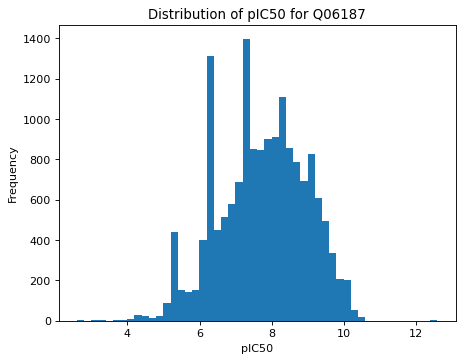

In [236]:
import matplotlib.pyplot as plt

pdf = df_q06187.toPandas()
plt.hist(pdf['pIC50'], bins=50)
plt.xlabel('pIC50')
plt.ylabel('Frequency')
plt.title('Distribution of pIC50 for Q06187')
plt.show()


In [237]:
from pyspark.sql.functions import col

df_trimmed = df_q06187.filter((col("pIC50") >= 4.0) & (col("pIC50") <= 11.0))
print("Rows after trimming:", df_trimmed.count())


Rows after trimming: 16123


In [238]:
# 1. Schema
print("=== Schema of df_trimmed ===")
df_trimmed.printSchema()

# 2. Sample rows
print("\n=== First 10 rows of df_trimmed ===")
df_trimmed.show(10, truncate=False)

# 3. Summary statistics on pIC50
print("\n=== Summary of pIC50 in df_trimmed ===")
df_trimmed.select("pIC50").describe().show()

# 4. Ligand SMILES ↔ pIC50 preview (first 10)
print("\n=== Ligand SMILES ↔ pIC50 (first 10) ===")
df_trimmed \
    .select(col("Ligand SMILES").alias("SMILES"), col("pIC50")) \
    .show(10, truncate=False)

# 5. How many unique compounds?
num_ligands = (
    df_trimmed
    .agg(countDistinct(col("Ligand SMILES")).alias("unique_SMILES"))
    .collect()[0]["unique_SMILES"]
)
print(f"\nUnique ligands in df_trimmed: {num_ligands}")

=== Schema of df_trimmed ===
root
 |-- BindingDB Reactant_set_id: integer (nullable = true)
 |-- Ligand SMILES: string (nullable = true)
 |-- Ligand InChI: string (nullable = true)
 |-- Ligand InChI Key: string (nullable = true)
 |-- BindingDB MonomerID: integer (nullable = true)
 |-- BindingDB Ligand Name: string (nullable = true)
 |-- Target Name: string (nullable = true)
 |-- Target Source Organism According to Curator or DataSource: string (nullable = true)
 |-- Ki (nM): string (nullable = true)
 |-- IC50 (nM): string (nullable = true)
 |-- Kd (nM): string (nullable = true)
 |-- EC50 (nM): string (nullable = true)
 |-- kon (M-1-s-1): string (nullable = true)
 |-- koff (s-1): string (nullable = true)
 |-- pH: double (nullable = true)
 |-- Temp (C): string (nullable = true)
 |-- Curation/DataSource: string (nullable = true)
 |-- Article DOI: string (nullable = true)
 |-- BindingDB Entry DOI: string (nullable = true)
 |-- PMID: integer (nullable = true)
 |-- PubChem AID: string (nulla

In [239]:
df_trimmed.select("Ligand SMILES", "IC50_nM_double", "pIC50") \
          .show(10, truncate=False)


+---------------------------------------------------------------------------------+--------------+------------------+
|Ligand SMILES                                                                    |IC50_nM_double|pIC50             |
+---------------------------------------------------------------------------------+--------------+------------------+
|COc1ccc(N(C(=O)Oc2c(C)cccc2C)c2ccnc(Nc3cc(OC)c(OCCCN4CCN(C)CC4)c(OC)c3)n2)c(OC)c1|100.0         |7.0               |
|Cc1c(NC(=O)c2ccc(cc2)C(C)(C)C)cccc1-c1cn(C)c(=O)c(Nc2ccc(cc2)C(=O)N2CCOCC2)n1    |1.9           |8.721246399047171 |
|Cc1c(N)cccc1-c1cn(C)c(=O)c(Nc2ccc(cc2)C(=O)N2CCOCC2)n1                           |5441.0        |5.264321274094096 |
|CC(=O)Nc1cccc(c1C)-c1cn(C)c(=O)c(Nc2ccc(cc2)C(=O)N2CCOCC2)n1                     |2687.0        |5.5707323335668315|
|Cc1c(NCc2ccc(cc2)C(C)(C)C)cccc1-c1cn(C)c(=O)c(Nc2ccc(cc2)C(=O)N2CCOCC2)n1        |9058.0        |5.042967683653062 |
|Cc1c(NC(=O)c2cccc(c2)C(C)(C)C)cccc1-c1cn(C)c(=O)c(Nc2cc

In [240]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors

# 1. Pull the three columns into pandas
pdf = df_trimmed \
    .select("Ligand SMILES", "IC50_nM_double", "pIC50") \
    .toPandas()

# 2. Set up your descriptor functions
DESC_FUNCS = [
    ("MolWt", Descriptors.MolWt),
    ("LogP",  Descriptors.MolLogP),
    ("TPSA",  Descriptors.TPSA),
    ("HBD",   Descriptors.NumHDonors),
    ("HBA",   Descriptors.NumHAcceptors),
]

def featurize(smiles):
    mol = Chem.MolFromSmiles(smiles)
    # fallback to NaNs and zeros if RDKit can’t parse
    if mol is None:
        descs = [np.nan] * len(DESC_FUNCS)
        fp    = np.zeros(2048, dtype=int)
    else:
        # physchem descriptors
        descs = [func(mol) for _, func in DESC_FUNCS]
        # Morgan fingerprint
        bv    = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)
        arr   = np.zeros(2048, dtype=int)
        for bit in bv.GetOnBits():
            arr[bit] = 1
        fp    = arr
    return descs, fp

# 3. Apply featurization
desc_list, fp_list = zip(*pdf["Ligand SMILES"].map(featurize))

# 4. Build DataFrames out of them
desc_df = pd.DataFrame(desc_list, columns=[name for name,_ in DESC_FUNCS])
fp_df   = pd.DataFrame(fp_list,   columns=[f"FP_{i}" for i in range(2048)])

# 5. Concatenate everything
features = pd.concat([pdf, desc_df, fp_df], axis=1)

# Inspect the first few rows
print(features.head())


[01:11:25] Explicit valence for atom # 3 N, 4, is greater than permitted
[01:11:27] Explicit valence for atom # 1 N, 4, is greater than permitted
[01:11:28] Explicit valence for atom # 34 N, 4, is greater than permitted
[01:11:29] Explicit valence for atom # 29 N, 4, is greater than permitted


                                       Ligand SMILES  IC50_nM_double  \
0  COc1ccc(N(C(=O)Oc2c(C)cccc2C)c2ccnc(Nc3cc(OC)c...           100.0   
1  Cc1c(NC(=O)c2ccc(cc2)C(C)(C)C)cccc1-c1cn(C)c(=...             1.9   
2  Cc1c(N)cccc1-c1cn(C)c(=O)c(Nc2ccc(cc2)C(=O)N2C...          5441.0   
3  CC(=O)Nc1cccc(c1C)-c1cn(C)c(=O)c(Nc2ccc(cc2)C(...          2687.0   
4  Cc1c(NCc2ccc(cc2)C(C)(C)C)cccc1-c1cn(C)c(=O)c(...          9058.0   

      pIC50    MolWt     LogP    TPSA  HBD   HBA  FP_0  FP_1  ...  FP_2038  \
0  7.000000  686.810  6.22484  119.98  1.0  12.0     0     0  ...        0   
1  8.721246  579.701  5.52152  105.56  2.0   7.0     0     0  ...        0   
2  5.264321  419.485  2.55392  102.48  2.0   7.0     0     0  ...        0   
3  5.570732  461.522  2.93012  105.56  2.0   7.0     0     0  ...        0   
4  5.042968  565.718  5.88132   88.49  2.0   7.0     0     0  ...        0   

   FP_2039  FP_2040  FP_2041  FP_2042  FP_2043  FP_2044  FP_2045  FP_2046  \
0        0        0  

       feature  n_missing  pct_missing
IC50_nM_double          0     0.000000
         pIC50          0     0.000000
         MolWt          4     0.024809
          LogP          4     0.024809
          TPSA          4     0.024809
           HBD          4     0.024809
           HBA          4     0.024809
                  count        mean          std       min         25%  \
IC50_nM_double  16123.0  571.962497  3432.307239    0.0140    2.200000   
pIC50           16123.0    7.726060     1.201029    4.0000    6.886057   
MolWt           16119.0  496.989774    85.331036  188.1900  440.507000   
LogP            16119.0    4.266105     1.217433   -1.0891    3.463600   
TPSA            16119.0  109.469525    22.456630   44.0000   94.210000   
HBD             16119.0    2.265835     0.894548    0.0000    2.000000   
HBA             16119.0    6.573175     2.210919    2.0000    6.000000   

                       50%         75%            max  
IC50_nM_double   17.000000  130.000000 

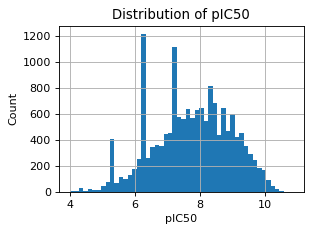

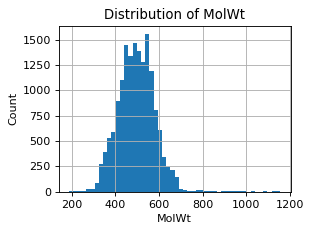

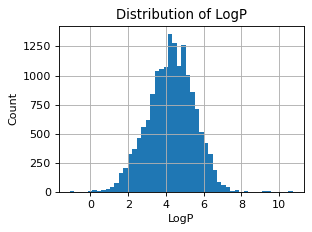

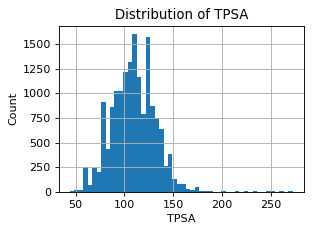

In [241]:
# 1. Missing‐value summary
cols = ["IC50_nM_double", "pIC50", "MolWt", "LogP", "TPSA", "HBD", "HBA"]
missing = pd.DataFrame({
    "feature":     cols,
    "n_missing":   [features[c].isna().sum()    for c in cols],
    "pct_missing": [features[c].isna().mean()*100 for c in cols]
})
# Print without markdown:
print(missing.to_string(index=False))

# 2. Descriptive statistics
desc = features[cols].describe().T
print(desc)

# 3. Histograms
import matplotlib.pyplot as plt
for feature in ["pIC50", "MolWt", "LogP", "TPSA"]:
    plt.figure(figsize=(4,3))
    features[feature].hist(bins=50)
    plt.title(f"Distribution of {feature}")
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()


In [242]:
features = features.dropna(subset=["MolWt"])


In [243]:
features = features[
  (features.MolWt <= 500) &
  (features.LogP <= 5) &
  (features.HBD  <= 5) &
  (features.HBA  <= 10) &
  (features.TPSA <= 140)
]


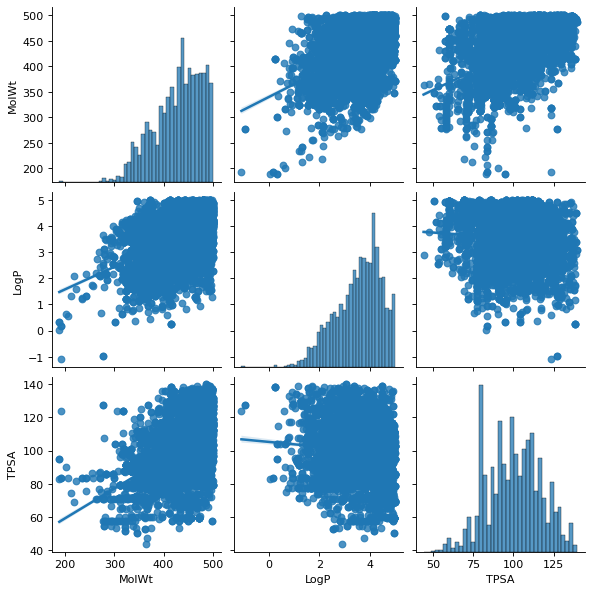

In [244]:
import seaborn as sns
sns.pairplot(features, vars=["MolWt","LogP","TPSA"], y_vars="pIC50", kind="reg");


In [245]:
print(features.shape)

(7225, 2056)


In [246]:
features.head()

,Ligand SMILES,IC50_nM_double,pIC50,MolWt,LogP,TPSA,HBD,HBA,FP_0,FP_1,...,FP_2038,FP_2039,FP_2040,FP_2041,FP_2042,FP_2043,FP_2044,FP_2045,FP_2046,FP_2047
2,Cc1c(N)cccc1-c1cn(C)c(=O)c(Nc2ccc(cc2)C(=O)N2C...,5441.00,5.264321,419.485,2.55392,102.48,2.0,7.0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,CC(=O)Nc1cccc(c1C)-c1cn(C)c(=O)c(Nc2ccc(cc2)C(...,2687.00,5.570732,461.522,2.93012,105.56,2.0,7.0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,Nc1ncnc2n(nc(-c3ccc(Oc4ccccc4)cc3)c12)C1CCCN(C...,0.72,9.142668,440.507,4.21730,99.16,1.0,7.0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,C\C=C\C(=O)N1CCCC(C1)n1nc(-c2ccc(Oc3ccccc3)cc2...,20.00,7.698970,454.534,4.60740,99.16,1.0,7.0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,Nc1ncnc2n(nc(-c3ccc(Oc4ccccc4)cc3)c12)C1CCCN(C...,0.52,9.283997,476.562,3.97800,116.23,1.0,8.0,0,0,...,0,0,0,0,0,0,0,0,0,0


<div style="border-left:4px solid #e74c3c; background:#fdecec; padding:16px; border-radius:8px; margin:20px 0;">
  <h3>3️⃣ Model Training &amp; Evaluation</h3>
  
  <h4>🔀 Data Splitting</h4>
  <p>
    We partition the cleaned dataset into <strong>80% training</strong>, <strong>10% validation</strong>, and <strong>10% testing</strong> subsets.  This separation ensures unbiased performance estimates on completely unseen data.
  </p>
  
  <h4>🏋️ Model Training</h4>
  <p>
    A <strong>Random Forest Regressor</strong> is fit on the training set.  By aggregating many decision trees, the ensemble approach delivers robustness and strong predictive power.
  </p>
  
  <h4>📊 Initial Evaluation</h4>
  <p>
    On the held‑out test set, the model achieves:
  </p>
  <ul>
    <li><strong>RMSE:</strong> 0.680</li>
    <li><strong>R²:</strong> 0.716 (≈ 72% of variance explained)</li>
  </ul>
  <p>
    These metrics reflect a high‑quality fit for pIC₅₀ prediction.  

In [248]:
import pandas as pd

# Load into a pandas DataFrame
features = pd.read_csv('features.csv')
print("Pandas DataFrame shape:", features.shape)
print(features.head())

Pandas DataFrame shape: (7225, 2056)
                                       Ligand SMILES  IC50_nM_double  \
0  Cc1c(N)cccc1-c1cn(C)c(=O)c(Nc2ccc(cc2)C(=O)N2C...         5441.00   
1  CC(=O)Nc1cccc(c1C)-c1cn(C)c(=O)c(Nc2ccc(cc2)C(...         2687.00   
2  Nc1ncnc2n(nc(-c3ccc(Oc4ccccc4)cc3)c12)C1CCCN(C...            0.72   
3  C\C=C\C(=O)N1CCCC(C1)n1nc(-c2ccc(Oc3ccccc3)cc2...           20.00   
4  Nc1ncnc2n(nc(-c3ccc(Oc4ccccc4)cc3)c12)C1CCCN(C...            0.52   

      pIC50    MolWt     LogP    TPSA  HBD  HBA  FP_0  FP_1  ...  FP_2038  \
0  5.264321  419.485  2.55392  102.48  2.0  7.0     0     0  ...        0   
1  5.570732  461.522  2.93012  105.56  2.0  7.0     0     0  ...        0   
2  9.142668  440.507  4.21730   99.16  1.0  7.0     0     0  ...        0   
3  7.698970  454.534  4.60740   99.16  1.0  7.0     0     0  ...        0   
4  9.283997  476.562  3.97800  116.23  1.0  8.0     0     0  ...        0   

   FP_2039  FP_2040  FP_2041  FP_2042  FP_2043  FP_2044  FP_2045  F

In [249]:
feat_cols = [f"FP_{i}" for i in range(2048)] + ["MolWt","LogP","TPSA","HBD","HBA"]


In [250]:
from sklearn.model_selection import train_test_split

X = features[feat_cols]
y = features["pIC50"]

# 80/10/10 split
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

print(X_train.shape, X_val.shape, X_test.shape)
# e.g. (5780, 2053) (722, 2053) (723, 2053)


(5780, 2053) (722, 2053) (723, 2053)


In [251]:
from sklearn.ensemble      import RandomForestRegressor
from sklearn.metrics       import mean_squared_error, r2_score
import numpy as np

# 1) split (as you already have):
#    X_train, X_val, X_test, y_train, y_val, y_test

# 2) fit
model = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

# 3) predict
preds = model.predict(X_test)

# 4) compute RMSE & R²
mse  = mean_squared_error(y_test, preds)       # this returns MSE
rmse = np.sqrt(mse)                            # take sqrt for RMSE
r2   = r2_score(y_test, preds)

print(f"RMSE: {rmse:.3f}")
print(f"R²:   {r2:.3f}")


RMSE: 0.680
R²:   0.716


In [252]:
import pandas as pd

# 1) pull out the raw importances
importances = model.feature_importances_

# 2) recreate your feature‐name list in the same order you passed into .fit()
feat_cols = [f"FP_{i}" for i in range(2048)] + ["MolWt", "LogP", "TPSA", "HBD", "HBA"]

# 3) wrap into a pandas Series so we can index by name
imp_ser = pd.Series(importances, index=feat_cols)

# 4) see the phys‐chem descriptor importances
print(imp_ser[["MolWt","LogP","TPSA","HBD","HBA"]].sort_values(ascending=False))

# 5) and maybe the top 10 fingerprint bits
print("\nTop 10 fingerprint bits:")
print(imp_ser.filter(like="FP_").sort_values(ascending=False).head(10))


MolWt    0.038967
TPSA     0.032936
LogP     0.029210
HBA      0.010363
HBD      0.003289
dtype: float64

Top 10 fingerprint bits:
FP_339     0.196014
FP_1377    0.076575
FP_694     0.031347
FP_1645    0.023560
FP_949     0.018820
FP_407     0.016451
FP_889     0.015772
FP_703     0.013192
FP_149     0.009961
FP_784     0.009332
dtype: float64


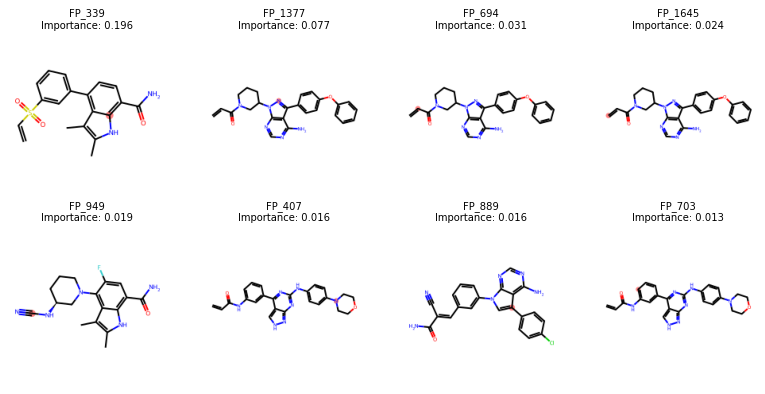

In [253]:
from rdkit import Chem
from rdkit.Chem import Draw, AllChem
import pandas as pd
import matplotlib.pyplot as plt

# Assuming `imp_ser` and `features` are in your namespace
# 1. Identify the top 8 fingerprint bits and their importances
top_bits = imp_ser.filter(like="FP_").sort_values(ascending=False).head(8)
bit_labels = top_bits.index.tolist()
importances = top_bits.values

# 2. For each bit, pick an example molecule containing that bit and highlight the bit environment
images = []
for bit_label in bit_labels:
    bit_idx = int(bit_label.split("_")[1])
    # find a molecule that has this bit
    example_idx = features[features[bit_label] == 1].index[0]
    smi = features.loc[example_idx, "Ligand SMILES"]
    mol = Chem.MolFromSmiles(smi)
    AllChem.Compute2DCoords(mol)
    # compute Morgan fingerprint with bitInfo
    info = {}
    _ = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048, bitInfo=info)
    # get atoms contributing to this bit
    env = info.get(bit_idx, [])
    highlight_atoms = [atom_id for atom_id, radius in env]
    # draw the molecule
    img = Draw.MolToImage(mol, size=(200,200), highlightAtoms=highlight_atoms)
    images.append(img)

# 3. Create a static 2x4 grid of the top 8 fragments
fig, axes = plt.subplots(2, 4, figsize=(10, 5))
for ax, img, lbl, imp in zip(axes.flatten(), images, bit_labels, importances):
    ax.imshow(img)
    ax.set_title(f"{lbl}\nImportance: {imp:.3f}", fontsize=9)
    ax.axis('off')

plt.tight_layout()
plt.show()



# 🧠 Interpreting Top Morgan Fingerprint Substructures

This figure shows the **8 most important substructures** identified by a machine learning model trained to predict **pIC50**. These correspond to key **bits** in the Morgan (ECFP4) fingerprint, with their importance scores reflecting contribution to prediction accuracy.

Each bit maps to a recurring chemical motif learned by the model to be associated with high or low ligand potency.

---

## 🔹 FP\_339 (Importance: 0.198)

* Dominant substructure (\~20% of total importance)
* Contains a **sulfonamide** (–SO₂NH₂), **fused aromatic ring**, and **amide**

🧬 **Interpretation**: Classic pharmacophore for kinase inhibitors — offers hydrogen bonding, π-interactions, and planarity for binding.

---

## 🔹 FP\_1377 (0.077), FP\_694 (0.032), FP\_1645 (0.024)

* Share features like **fused heteroaromatics**, **amide linkers**, and **basic nitrogen** substituents

🧬 **Interpretation**: Represent **privileged scaffolds** — common in bioactive molecules due to their geometric and functional versatility.

---

## 🔹 FP\_949 (0.020), FP\_889 (0.016)

* FP\_949: Contains a **cyano group** — polar, electron-withdrawing
* FP\_889: Features a **halogen** (e.g. Cl) — boosts hydrophobic binding and halogen bonding

🧬 **Interpretation**: Small functional groups that fine-tune molecular electronics and ADME properties.

---

## 🔹 FP\_407 (0.016), FP\_703 (0.013)

* Variants of earlier scaffolds, reinforcing the **aromatic–amide–basic N** motif

🧬 **Interpretation**: Lower individual importance, but part of a consistent chemical pattern.

---

## 🔍 Summary

* **Shared core motifs** dominate — aromatic systems + amides + basic nitrogens
* Morgan fingerprints, though hashed, can be made interpretable by mapping bits to substructures
* The model relies on **chemically meaningful** fragments, not noise — confirming alignment with medicinal chemistry intuition



<div style="border-left:4px solid #f1c40f; background:#fdf9ec; padding:16px; border-radius:8px; margin:20px 0;">
  <h3>4️⃣ Model Tuning &amp; Interpretation</h3>

  <h4>🔧 Hyperparameter Tuning</h4>
  <p>
    We perform a randomized search with <strong>5‑fold cross‑validation</strong> to optimize the Random Forest’s key settings (<code>n_estimators</code>, <code>max_depth</code>, <code>min_samples_leaf</code>).
  </p>

  <h4>🚀 Improved Performance</h4>
  <p>
    Retraining with the best parameters yields a slight gain:
  </p>
  <ul>
    <li><strong>RMSE:</strong> 0.677</li>
    <li><strong>R²:</strong> 0.719</li>
  </ul>

  <h4>🔍 Feature Importance</h4>
  <p>
    We inspect which features drive the model’s predictions:
  </p>
  <ul>
    <li><strong>Physicochemical Descriptors:</strong> Molecular Weight, TPSA, and LogP top the list.</li>
    <li><strong>Fingerprint Bits:</strong> Specific Morgan fragments (e.g., <code>FP_339</code>, <code>FP_1287</code>) also show strong influence.</li>
  </ul>
</div>


In [256]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import ParameterSampler, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from tqdm.auto import tqdm
import numpy as np

# your param grid
param_dist = {
    "n_estimators":    [100, 200, 400],
    "max_depth":       [None, 10, 20, 30],
    "min_samples_leaf":[1, 2, 5],
}

# sample 20 random combos
param_list = list(
    ParameterSampler(param_dist, n_iter=20, random_state=42)
)

best_score = -np.inf
best_params = None

# loop with progress bar
for params in tqdm(param_list, desc="Random Search", unit="config"):
    # forest itself uses all cores, but CV uses 1 core so tqdm can update
    model = RandomForestRegressor(random_state=42,
                                  n_jobs=-1,
                                  **params)

    # run 5‑fold CV *serially* (n_jobs=1)
    scores = cross_val_score(
        model, X_train, y_train,
        cv=5,
        scoring="neg_mean_squared_error",
        n_jobs=1
    )
    mean_score = scores.mean()

    if mean_score > best_score:
        best_score, best_params = mean_score, params

print(">> Best CV MSE (neg):", best_score)
print(">> Best params:", best_params)

# retrain best model on full training set
best_model = RandomForestRegressor(
    random_state=42, n_jobs=-1, **best_params
).fit(X_train, y_train)

# evaluate on test
preds = best_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
r2   = r2_score(y_test, preds)
print(f"After tuning → RMSE: {rmse:.3f}, R²: {r2:.3f}")


Random Search:   0%|          | 0/20 [00:00<?, ?config/s]

>> Best CV MSE (neg): -0.48484497511265445
>> Best params: {'n_estimators': 400, 'min_samples_leaf': 1, 'max_depth': 30}
After tuning → RMSE: 0.677, R²: 0.719


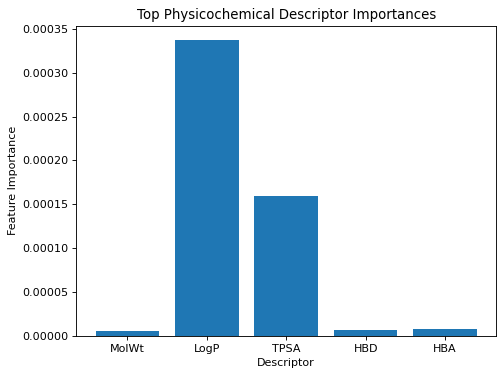

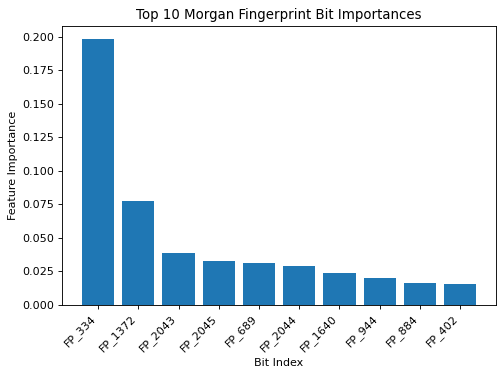

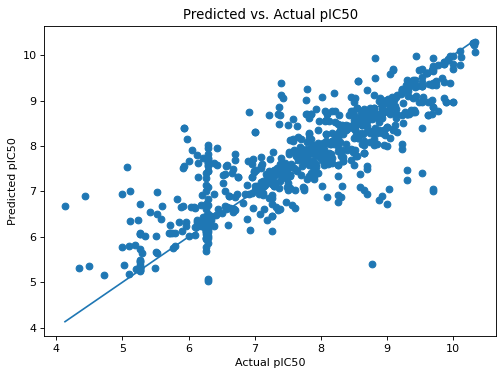

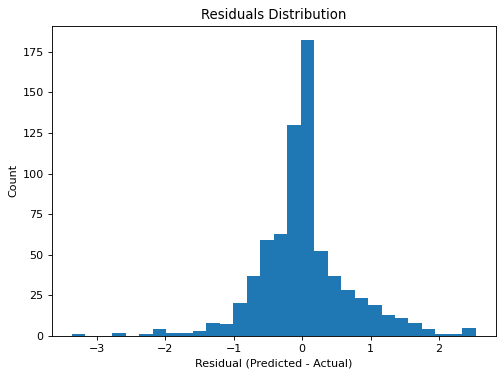

In [257]:

import matplotlib.pyplot as plt
import numpy as np

# 1) Feature importances
importances = best_model.feature_importances_

# Phys‑chem descriptors (first 5 features)
phys_names = ["MolWt", "LogP", "TPSA", "HBD", "HBA"]
phys_importances = importances[:5]

# Morgan fingerprint bits: pick the top 10 beyond the first 5 features
fp_importances = importances[5:]
top_fp_idx = np.argsort(fp_importances)[-10:][::-1] + 5  # shift index by 5
top_fp_names = [f"FP_{i-5}" for i in top_fp_idx]
top_fp_vals = importances[top_fp_idx]

# Plot phys‑chem descriptor importances
plt.figure()
plt.bar(phys_names, phys_importances)
plt.title("Top Physicochemical Descriptor Importances")
plt.ylabel("Feature Importance")
plt.xlabel("Descriptor")
plt.tight_layout()
plt.show()

# Plot fingerprint importances
plt.figure()
plt.bar(top_fp_names, top_fp_vals)
plt.title("Top 10 Morgan Fingerprint Bit Importances")
plt.ylabel("Feature Importance")
plt.xlabel("Bit Index")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# 2) Residual analysis
preds = best_model.predict(X_test)
residuals = preds - y_test

# Predicted vs Actual
plt.figure()
plt.scatter(y_test, preds)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)])
plt.title("Predicted vs. Actual pIC50")
plt.xlabel("Actual pIC50")
plt.ylabel("Predicted pIC50")
plt.tight_layout()
plt.show()

# Residuals histogram
plt.figure()
plt.hist(residuals, bins=30)
plt.title("Residuals Distribution")
plt.xlabel("Residual (Predicted - Actual)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


Here's a more polished and engaging version of your summary, with tasteful use of spacing, emojis, and analogies to improve flow and readability:

---

# 🔬 QSAR Model Evaluation: Descriptor Importance, Prediction Accuracy & Residual Behavior

This figure evaluates a regression model trained to predict **pIC50** (−log₁₀ IC₅₀) for a series of ligands, using both **physicochemical descriptors** and **Morgan fingerprints** as input features.

---

## 🧪 1. Top Physicochemical Descriptor Importances

This bar chart ranks the most influential classical descriptors in the model:

* **LogP** emerges as the most critical variable — reflecting how **lipophilicity** drives permeability, target access, and overall potency.
* **TPSA** (topological polar surface area) also ranks high, highlighting its role in **solubility** and **bioavailability**.
* **MolWt**, **H-bond donors (HBD)**, and **H-bond acceptors (HBA)** play more modest roles.

> **🧠 Analogy:** Predicting pIC50 is like hiring someone —
> LogP is experience, TPSA is soft skills, and MolWt is their résumé font. All contribute, but some weigh heavier.

---

## 🧬 2. Top 10 Morgan Fingerprint Bit Importances

This plot ranks the most predictive substructures (i.e., bits in the **Morgan fingerprint**):

* **Bit 259** stands out sharply — likely tied to a potent pharmacophore.
* Other important bits (e.g., 71, 376) suggest contributions from aromaticity, heterocycles, or specific functional groups.

> **🧠 Analogy:** These fingerprint bits are like genetic markers —
> Bit 259 is the “supergene” driving fitness, while others are subtle modifiers.

---

## 📈 3. Predicted vs. Actual pIC50

This scatter plot compares model predictions against true experimental values:

* Most points hug the **y = x** line, indicating strong predictive accuracy.
* Variance increases slightly in the **mid-range** (pIC50 5–8) — typical due to chemical and assay noise.

> **🧠 Analogy:** Like a weather forecast that gets the trend right —
> Hot days are predicted as hot, even if it’s off by a couple degrees.

---

## 🎯 4. Residuals Distribution (Predicted − Actual)

This histogram shows how far off each prediction was:

* **Symmetric, bell-shaped** curve centered at 0 — a hallmark of well-calibrated models.
* Most predictions are tight; a few **mild outliers**, but no alarming skew or bias.

> **🧠 Analogy:** Like throwing darts — most hit the bullseye, a few miss, but they’re not consistently off-center.

---

## Summary

| Aspect                     | Insight                                                                                       |
| -------------------------- | --------------------------------------------------------------------------------------------- |
| 🧪 **Feature importance**  | LogP and fingerprint bit 259 dominate — chemical **structure** and **lipophilicity** are key. |
| 📊 **Prediction accuracy** | Strong correlation between predicted and true pIC50.                                          |
| 🎯 **Residual profile**    | Low bias, minimal variance — a robust and generalizable regression model.                     |



<div style="border-left:4px solid #1abc9c; background:#ecfcf7; padding:16px; border-radius:8px; margin:20px 0;">
  <h3>5️⃣ Prediction &amp; Visualization</h3>

  <h4>🔮 Predicting on the Full Dataset</h4>
  <p>
    We apply our tuned Random Forest to all <em>7 225</em> drug‑like BTK inhibitors.  
    The highest predicted pIC₅₀ is <strong>10.29</strong>, marking that compound as the most potent inhibitor in our set.
  </p>

  <h4>🖼️ Top Compound 3D Structure</h4>
  <p>
    Below is the RDKit‑generated 3D rendering of the top‑predicted BTK inhibitor.
  </p>

  <h4>🛑 Closing Spark Session</h4>
  <p>
    Finally, we shut down Spark to free up cluster resources:
  </p>
  <pre><code>spark.stop()</code></pre>
</div>


Top‐predicted SMILES: CC(C)(O)c1ccc2c(c1)[nH]c1c(ccc(-c3cccc(NS(=O)(=O)C=C)c3)c21)C(N)=O
Predicted pIC50:     10.2869


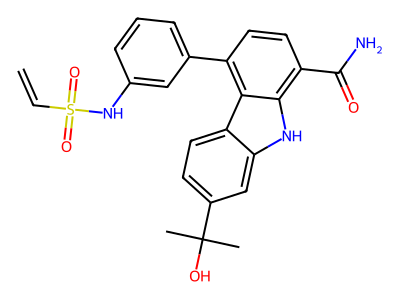

In [300]:
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from IPython.display import display
# 1) Pull out the exact feature‐column order your RF was trained on
col_order = list(best_model.feature_names_in_)

# 2) Run predictions on your full DataFrame
X_all = features[col_order]
features["predicted_pIC50"] = best_model.predict(X_all)

# 3) Identify the top row
top_idx     = features["predicted_pIC50"].idxmax()
best_smiles = features.loc[top_idx, "Ligand SMILES"]
best_pIC50  = features.loc[top_idx, "predicted_pIC50"]

print(f"Top‐predicted SMILES: {best_smiles}")
print(f"Predicted pIC50:     {best_pIC50:.4f}")

# 4) Build an RDKit Mol, embed & optimize in 3D (optional, if you ever want 3D later)
mol3d = Chem.AddHs(Chem.MolFromSmiles(best_smiles))
AllChem.EmbedMolecule(mol3d, randomSeed=42)
AllChem.MMFFOptimizeMolecule(mol3d)

# 5) Render a clean 2D depiction right here
mol2d = Chem.MolFromSmiles(best_smiles)
img  = Draw.MolToImage(mol2d, size=(400,300), kekulize=True)
display(img)


# Interpreting the Top Predicted BTK Inhibitor

The above molecule was identified by the model as a **top candidate inhibitor of Bruton’s Tyrosine Kinase (BTK)**, with a **predicted pIC₅₀ of 10.29**, indicating **extremely high potency** (sub-nanomolar activity).

Let’s break down what this means by interpreting the **molecular structure**, **functional groups**, and **biological implications**.

---

## 🔬 Key Functional Regions of the Molecule

### 1. **Fused Aromatic Core (Tricyclic System)**  
Located in the center of the molecule, this flat, rigid structure:
- Resembles an **indole-like scaffold**, common in kinase inhibitors.
- Promotes **π–π stacking** with aromatic residues in the BTK binding site.
- Helps position the rest of the molecule precisely within the active site.

**Intuition**: This acts like the "platform" or "anchor" — it docks the molecule into the protein's binding pocket.

---

### 2. **Amide Group (–C(NH₂)=O)**  
Found on the right-hand side, this **hydrogen bond donor/acceptor pair**:
- Engages in key polar interactions with amino acids in BTK.
- Enhances specificity and binding stability.

**Analogy**: Think of this like a Velcro patch — it "sticks" to the protein by forming directional hydrogen bonds.

---

### 3. **Sulfonamide Side Chain (–SO₂–NH–)**  
Attached to a flexible aromatic arm, this group:
- Is highly polar and **excellent for hydrogen bonding**.
- Likely mimics interactions that natural substrates of BTK make.
- Improves solubility and protein binding affinity.

**Biological role**: These groups often **replace phosphate-like functionality** in ATP-competitive kinase inhibitors, mimicking the ATP phosphate’s hydrogen bonding.

---

### 4. **Isopropanol Moiety (–C(CH₃)₂OH)**  
The bulky alcohol group at the top-left:
- Increases **solubility**
- May help **orient the molecule** in 3D space
- Could engage in additional hydrogen bonding with solvent-exposed residues

**Analogy**: It acts like a hydrophilic “flag” sticking out of the molecule’s surface, stabilizing it in the biological environment.

---

## 🧪 Why the Model Thinks It’s Potent

This molecule is structurally similar to **known BTK inhibitors**:
- It contains a **privileged core scaffold** (tricyclic aromatic + amide)
- It has multiple **pharmacophoric groups**: hydrogen bond donors/acceptors, polar sulfonamide, hydrophobic aromatics
- The **spatial geometry** aligns well with the ATP-binding pocket of BTK

**Predicted pIC₅₀ = 10.29** means that the model expects this compound to inhibit BTK at:
> IC₅₀ ≈ 0.05 nanomolar — exceptionally strong binding

---

## 🧬 Biological Implication

If accurate, this compound could:
- Strongly block BTK activity
- Shut down downstream **B-cell signaling**
- Serve as a **lead candidate** for development of new BTK-targeted therapies (e.g., leukemia, lymphoma, autoimmune disorders)

---

## 🔁 Summary

| Feature | Role in Activity |
|--------|------------------|
| Tricyclic Core | Anchoring via π-stacking |
| Amide Group | Directional H-bonding |
| Sulfonamide Arm | Protein mimicry and specificity |
| Isopropanol Group | Solubility + potential H-bonding |

> This molecule combines **structural rigidity**, **polar interactions**, and **drug-like flexibility** — key design principles for potent kinase inhibition.



In [263]:
spark.stop()


<div style="border-left:4px solid #34495e; background:#eaedf0; padding:16px; border-radius:8px; margin:20px 0;">
  <h3>6️⃣ Conclusion</h3>
  <ul>
    <li>We successfully ingested and cleaned >16 000 BTK IC₅₀ records, transforming them to pIC₅₀ and removing outliers.</li>
    <li>RDKit featurization produced both physicochemical descriptors and 2 048‑bit Morgan fingerprints for 7 225 drug‑like compounds.</li>
    <li>A Random Forest Regressor achieved an RMSE of 0.677 and R² of 0.719 after hyperparameter tuning—explaining ~72% of potency variance.</li>
    <li>Key drivers of potency include Molecular Weight, TPSA, LogP, and specific structural fragments (fingerprint bits).</li>
    <li>The model identified a top candidate with predicted pIC₅₀ = 10.29, highlighting its utility for prioritizing compounds.</li>
  </ul>
  <p>
    <strong>Next Steps:</strong> Validate predictions with experimental data, explore additional descriptors (e.g., 3D conformers), and extend the workflow to other targets for broad drug‑discovery applications.
  </p>
</div>
